# Webinar 4. Training with a teacher

**Lesson Plan**

**План занятия**
* [Intro](#intro)
* [Step 1: Data Upload](#load)
* [Step 2: EDA and data cleaning](#eda)
* [Step 3: Data cleaning and Feature engineering](#preprocess)
* [Step 4: Train / test](#split)
* [Step 5: Model](#model)
    * [5.1 Linear Regression](#linear)
    * [5.2 Decision tree](#tree)
    * [5.3 Random Forest](#rf)
    * [5.4 Gradient Boosting decision trees](#boost)
* [Step 6.* Setting up and assessing the final model](#cross_val)


Will be updated

## Introduction <a class='anchor' id='intro'>

**Training with the teacher** = there is a target variable that we predict

_Regression_ - targeting is continuous
- Prediction of house prices
- Prediction of demand for goods
- ...


_Classification_ - Target takes 2 (sometimes k) values
- Credit scoring: repayment of loan (target=0) or not (target=1)
- Determination of animal species by photo (0 - lion, 1 - panther, 2 - leopard, ... , k - cheetah) 
- ...

**Learning without a teacher** = no target variable:
- Division of data into groups
- ...
_______________

**Reinforced training** - the test system (agent) is trained by interacting with a certain environment
<table><tr>
<td> <img src="openai1.gif" style="width: 600px;"/> </td>.
<td> <img src="unnamed.gif" style="width: 450px;"/> </td>.
</tr></table>

_________
**What does the classification refer to?**<br>
1. Prediction of a student's grade on a five-point scale at an exam 
2. Prediction of demand for goods
3. Search for similar user groups
4. Division of books into artistic and scientific

**Steps of the Data Science project:**

1. Identify the business problem
2. Convincing the business that it can and should be solved with ML
3. Translate business problem into ML task
4. Select the appropriate ML and business metrics
---------------------------------------------------------------------------
5. Data upload
6. EDA: data visualisation (webinar 3)
7. Data cleansing and engineering (webinar 2)
8. **_Division of data into train and test_**
9. **_Constructing ML models_**
10. **_Quality assessment of ML models and selection of the best_**

---------------------------------------------------------------------------
11. Prove to the business customer that the model works well
12. Implementation of the model in production
13. Model improvement
14. Model support

**Connection of libraries and scripts**.

In [4]:
import numpy as np
import pandas as pd
import pickle

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error as mse, r2_score as r2

from IPython.display import Image

In [5]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

**Pathways to directories and files**

In [6]:
DATASET_PATH = 'housing.csv'
PREPARED_DATASET_PATH = 'housing_prepared.csv'

REPORTS_FILE_PATH = 'reports/'
SCALER_FILE_PATH = 'models/scaler.pkl'
MODEL_FILE_PATH = 'models/model.pkl'

# Step 1: Data upload <a class='anchor' id='load'>

For **reduce_mem_usage** see webinar 3

In [7]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

**Description of the dataset**

Statistics on a number of houses in California, based on the 1990 census.

* **longitude**
* **latitude**
* **housing_median_age**
* **total_rooms**
* **total_bedrooms**
* **population**
* **households**
* **ocean_proximity**
* **median_income**
* **median_house_value**

In [8]:
df = pd.read_csv(DATASET_PATH, sep=';')
df = reduce_mem_usage(df)
df.head()

Memory usage of dataframe is 2.83 MB
Memory usage after optimization is: 1.06 MB
Decreased by 62.5%


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,bedroom_share,population_per_room,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,median_rooms
0,-122.230003,37.880001,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,14.659091,0.365909,0,0,0,1,0,2083.0
1,-122.220001,37.860001,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,15.579659,0.338217,0,0,0,1,0,2083.0
2,-122.239998,37.849998,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,12.951602,0.338105,0,0,0,1,0,2083.0
3,-122.250000,37.849998,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,18.445839,0.437991,0,0,0,1,0,2083.0
4,-122.250000,37.849998,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,17.209589,0.347265,0,0,0,1,0,2083.0


In [9]:
df.dtypes

longitude               float32
latitude                float32
housing_median_age      float32
total_rooms             float32
total_bedrooms          float32
population              float32
households              float32
median_income           float32
median_house_value      float32
ocean_proximity        category
bedroom_share           float32
population_per_room     float32
<1H OCEAN                  int8
INLAND                     int8
ISLAND                     int8
NEAR BAY                   int8
NEAR OCEAN                 int8
median_rooms            float32
dtype: object

# Step 2. EDA and data cleaning <a class='anchor' id='eda'>

* In this webinar we will not stop at EDA, but in the project we have to do it - __see webinar 3__.

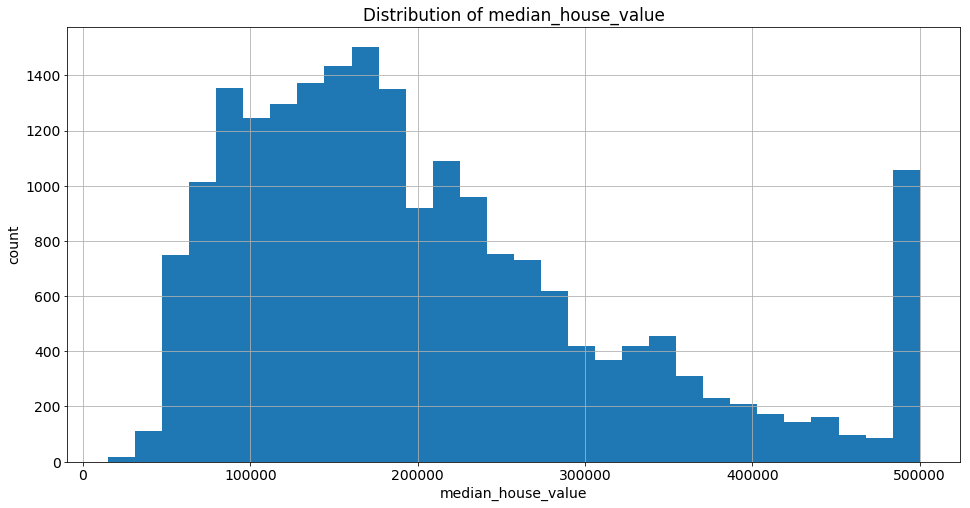

In [10]:
plt.figure(figsize = (16, 8))

df['median_house_value'].hist(bins=30)
plt.ylabel('count')
plt.xlabel('median_house_value')

plt.title('Distribution of median_house_value')
plt.show()

In [11]:
df = df[df['median_house_value'] <= 500000].reset_index()

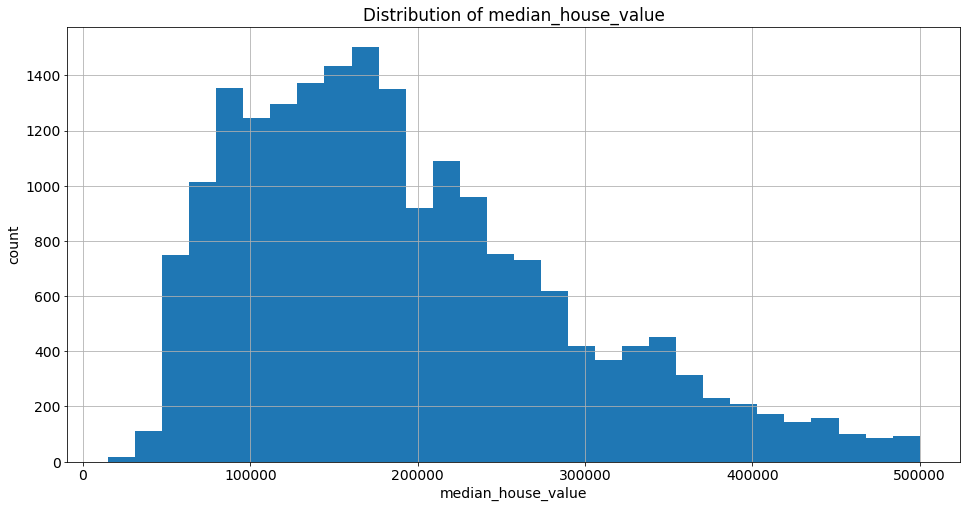

In [12]:
plt.figure(figsize = (16, 8))

df['median_house_value'].hist(bins=30)
plt.ylabel('count')
plt.xlabel('median_house_value')

plt.title('Distribution of median_house_value')
plt.show()

* For example, you can look at webinar 2: __class DataPipeline__.

In [16]:
class DataPipeline:
    """Prep data"""
    
    def __init__(self):
        """Class params"""
        # <your code>
        
    def fit(self, df):
        """Saving statistics"""
        # <your code>
        
    def transform(self, df):
        """Transformation of data"""
        # <your code>

**Leave the features that are necessary for the model**

In [17]:
df.columns.tolist()

['index',
 'longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity',
 'bedroom_share',
 'population_per_room',
 '<1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN',
 'median_rooms']

In [18]:
feature_names = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 
                 'households', 'median_income', '<1H OCEAN', 'INLAND', 'NEAR BAY', 'NEAR OCEAN']

target_name = 'median_house_value'

In [19]:
df = df[feature_names + [target_name]]
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN,median_house_value
0,-122.230003,37.880001,41.0,880.0,129.0,322.0,126.0,8.3252,0,0,1,0,452600.0
1,-122.220001,37.860001,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,0,0,1,0,358500.0
2,-122.239998,37.849998,52.0,1467.0,190.0,496.0,177.0,7.2574,0,0,1,0,352100.0
3,-122.250000,37.849998,52.0,1274.0,235.0,558.0,219.0,5.6431,0,0,1,0,341300.0
4,-122.250000,37.849998,52.0,1627.0,280.0,565.0,259.0,3.8462,0,0,1,0,342200.0


**Standardization of features** 

In [20]:
feature_names_for_stand = df[feature_names].select_dtypes(include=['float32', 'float16']).columns.tolist()
feature_names_for_stand

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [21]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(df[feature_names_for_stand])

In [22]:
stand_features

array([[-1.32964089,  1.03664427,  1.0243417 , ..., -0.98255785,
        -0.97894646,  2.9603804 ],
       [-1.32465472,  1.02734021, -0.60423181, ...,  0.85655696,
         1.66159385,  2.94522346],
       [-1.33462326,  1.02268729,  1.92005713, ..., -0.82863482,
        -0.84587575,  2.28035334],
       ..., 
       [ 0.61953713, -1.07998233,  1.92005713, ..., -0.61898104,
        -0.55625127, -0.18221321],
       [ 0.61953713, -1.07533119,  1.92005713, ..., -0.96575016,
        -0.89023265, -0.59903068],
       [ 0.53977362, -1.03346377,  0.04719759, ..., -0.89409634,
        -0.85631267, -0.68303107]])

In [23]:
stand_features.shape

(19675, 8)

In [24]:
df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)

In [25]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN,median_house_value
0,-1.329641,1.036644,1.024342,-0.797584,-0.974311,-0.982558,-0.978946,2.960380,0,0,1,0,452600.0
1,-1.324655,1.027340,-0.604232,2.053478,1.349771,0.856557,1.661594,2.945223,0,0,1,0,358500.0
2,-1.334623,1.022687,1.920057,-0.528477,-0.829205,-0.828635,-0.845876,2.280353,0,0,1,0,352100.0
3,-1.339609,1.022687,1.920057,-0.616957,-0.722159,-0.773789,-0.736288,1.252288,0,0,1,0,341300.0
4,-1.339609,1.022687,1.920057,-0.455126,-0.615113,-0.767596,-0.631919,0.107935,0,0,1,0,342200.0


### Saving of dataset

In [26]:
df.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8', sep=';')

# Step 4: Breakdown on train / test <a class='anchor' id='split'>

In [27]:
X = df[feature_names]
y = df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

# Step 5: Building models <a class='anchor' id='model' >

    ML metrics - Mean Squared Error (**MSE**) 
    - MSE is directly proportional to RMSE and R^2
    - MSE is easy to optimize (take derivatives)
    - MSE is used "under the bonnet" of our ML models.



Business metrics - **R^2**, Root Mean Squared Error (**RMSE**)
    - Business metrics are interpreted
    - Understandable to business
    - We show it to business
    - RMSE - how much, on average, $ we are wrong in forecasting prices 
    - R^2 takes values from 0 to 1, if 1 - all predictions are perfect. We can say that this is the "accuracy" of the model

Best model - model with the smallest MSE on test 

$$MSE = \frac{1}{n}  \sum{(y - y_{pred})^2}$$

$$RMSE = \sqrt{\frac{1}{n}  \sum{(y - y_{pred})^2}}$$

$$R^2 = 1 - \frac{\frac{1}{n}\sum{(y - y_{pred})^2}}{\frac{1}{n}\sum{(y - y_{mean})^2}}$$

In [28]:
def evaluate_preds(true_values, pred_values, save=False):
    """Evaluating the model preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

### 5.1 Linear Regression  <a class='anchor' id='linear'>

<img src='linear_reg.png' width=500px>

$$price_{pred} = a_0 + a_1 * households + a_2 * rooms$$

$$Loss = MSE = \frac{1}{n}\sum{(price - price_{pred})^2}$$

$$Loss = MSE = \frac{1}{n}\sum{(price - (a_0 + a_1 * households + a_2 * rooms))^2}$$

$dx^2 = 2x$

$d4x = 4$

We find derivatives by parameters and solve a system of 3 equations with 3 unknowns:

$$\frac{dLoss}{da_0} = \frac{1}{n}\sum{2*(price-(a_0 + a_1 *households + a_2*rooms)) * 1} = 0 $$  
$$\frac{dLoss}{da_1} = \frac{1}{n}\sum{2*(price-(a_0 + a_1 *households + a_2*rooms)) * households} = 0 $$  
$$\frac{dLoss}{da_2} = \frac{1}{n}\sum{2*(price-(a_0 + a_1 *households + a_2*rooms)) * rooms} = 0 $$ 

R2:	0.612
RMSE:	60526.389
MSE:	3663443818.47


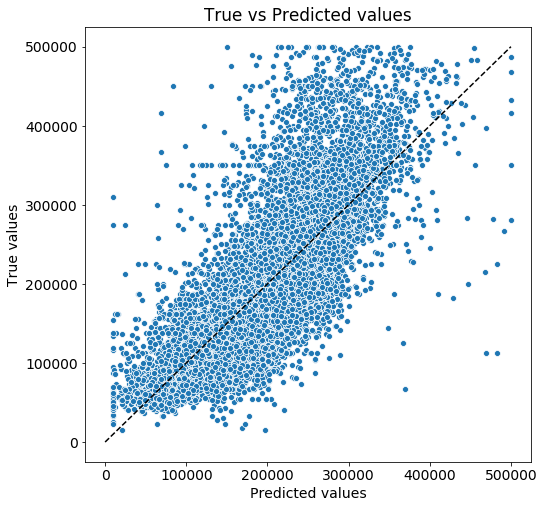

In [30]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_preds = lr_model.predict(X_train)
# Post-processing
y_train_preds = np.clip(y_train_preds, a_min=10000, a_max=500000)

evaluate_preds(y_train, y_train_preds)

R2:	0.609
RMSE:	61780.777
MSE:	3816864412.69


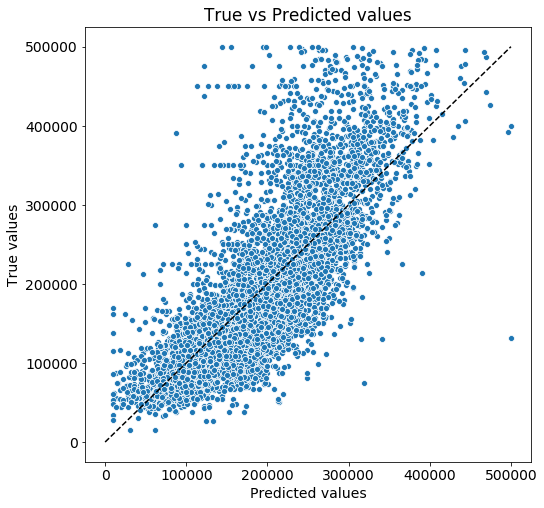

In [31]:
y_test_preds = lr_model.predict(X_test)

# Post-processing
y_test_preds = np.clip(y_test_preds, a_min=10000, a_max=500000)

evaluate_preds(y_test, y_test_preds)

### 5.2 Decision tree  <a class='anchor' id='tree'>

Using an example of a task: _How much time will a person spend on online games?_ (0 - 24 hours/day)

<img src='dt_explained.png'>

The decision tree can model dependencies of this type:

<img src='dt_example.png'>

R2:	0.75
RMSE:	48569.021
MSE:	2358949797.16


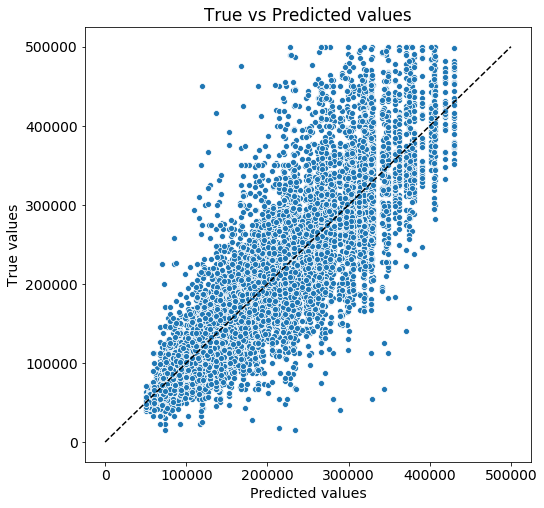

In [32]:
dt_model = DecisionTreeRegressor(criterion='mse', 
                                 max_depth=20, 
                                 min_samples_leaf=30,
                                 random_state=42)
dt_model.fit(X_train, y_train)

y_train_preds = dt_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.692
RMSE:	54869.668
MSE:	3010680435.36


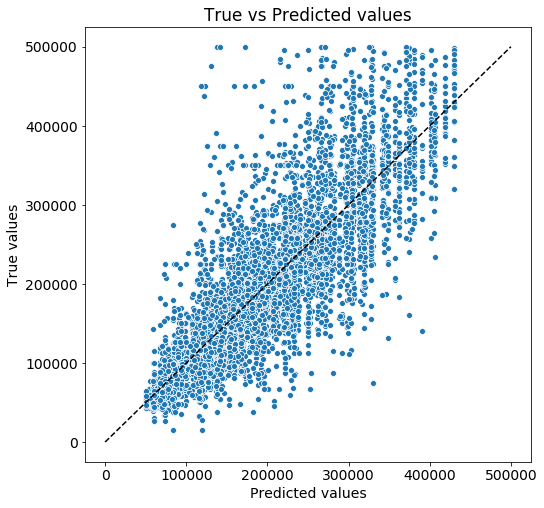

In [33]:
y_test_preds = dt_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

### 5.3 Random Forest  <a class='anchor' id='rf'>

**Trees are built independently**. Their **forecasts are averaged**

The element of randomness is added to make the trees different:
- each tree is built on a subsample of data (70% of data is randomly sampled)
- each tree is built on a subsample of fit (70% of fit is randomly sampled)
- ...

<img src='rf_explained.png'>

R2:	0.768
RMSE:	46765.805
MSE:	2187040502.53


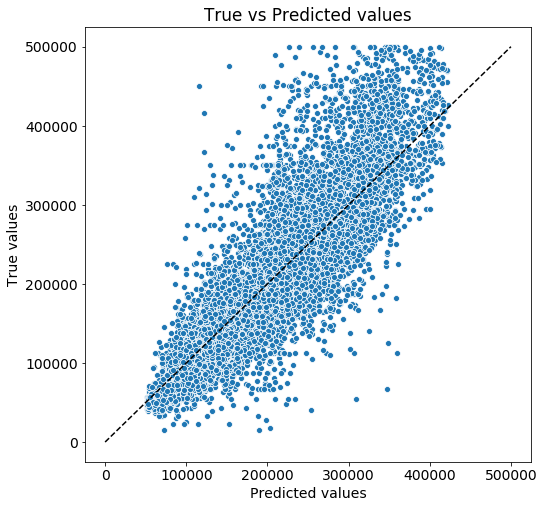

In [35]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=20,
                                 min_samples_leaf=30,
                                 random_state=42,
                                 n_estimators=100
                                 )

rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.722
RMSE:	52091.618
MSE:	2713536664.32


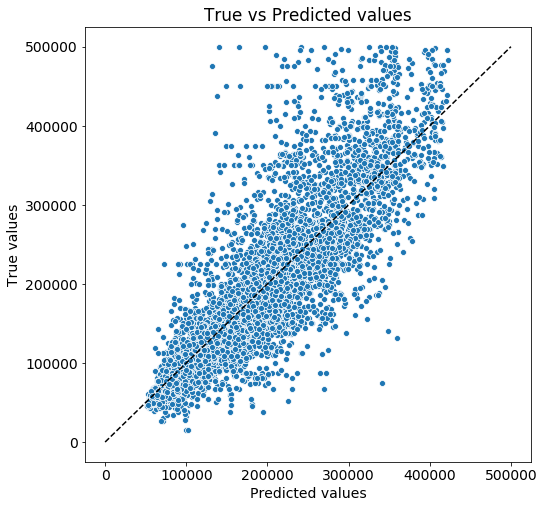

In [36]:
y_test_preds = rf_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

### 5.4 Gradient Boosting decision trees  <a class='anchor' id='boost'>

**N trees are built in sequence**: a new tree learns from the mistakes of previous trees. **Tree predictions are summed up**

<img src='gb_explained.png'>

In [38]:
y = np.array([10, 20, 30, 5, 10])

# First tree
y_pred_1 = np.array([8, 25, 34, 10, 3])
error_1 = y - y_pred_1

error_1

array([ 2, -5, -4, -5,  7])

In [39]:
gb_pred = y_pred_1
r2(y, gb_pred)

0.70250000000000001

In [40]:
# Second tree: target = error from the first one (error_1)
y_2 = error_1
y_pred_2 = np.array([1, -4, -2, -1, 3])

error_2 = y_2 - y_pred_2
error_2

array([ 1, -1, -2, -4,  4])

In [41]:
gb_pred = y_pred_1 + y_pred_2
r2(y, gb_pred)

0.90500000000000003

In [42]:
# Third tree's target = error from the second one (error_2)
y_3 = error_2
y_pred_3 = np.array([0, -1, -1, -1, 1])

error_2 = y_3 - y_pred_3
error_2

array([ 1,  0, -1, -3,  3])

In [43]:
gb_pred = y_pred_1 + y_pred_2 + y_pred_3
r2(y, gb_pred)

0.94999999999999996

R2:	0.897
RMSE:	31148.463
MSE:	970226732.155


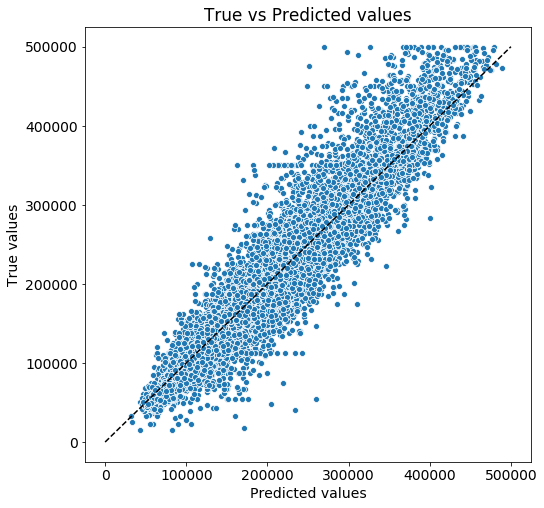

In [44]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=100)
gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.799
RMSE:	44362.007
MSE:	1967987694.58


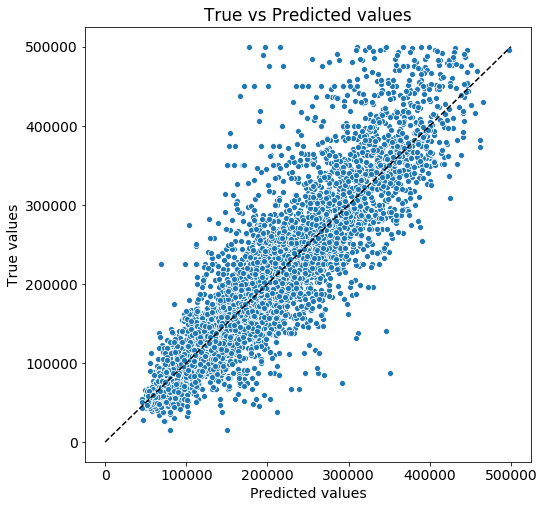

In [45]:
y_test_preds = gb_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

# Step 6.* Setting up and assessing the final model<a class='anchor' id='cross_val'>

!!! cross-validation takes place on the Train, we do not touch it !!!

In [46]:
X_train.shape[0] // 5

2636

In [47]:
X_train.reset_index(inplace=True, drop=True)
y_train = pd.DataFrame(y_train).reset_index(drop=True)

In [48]:
# One model (same parameters)

# Iteration_1
X_train__val_1 = X_train.iloc[:2500]
y_train__val_1 = y_train.iloc[:2500]

X_train__train_1 = X_train.iloc[2500:]
y_train__train_1 = y_train.iloc[2500:]


# teach model on X_train__train_1, y_train__train_1
# predict on X_train__val_1, y_train__val_1
# R2__1 = r2(y_pred__val_1, y_train__val_1) = 0.83


# Iteration_2
X_train__val_2 = X_train.iloc[2500:5000]
y_train__val_2 = y_train.iloc[2500:5000]

X_train__train_2 = X_train.drop(np.arange(2500, 5000))
y_train__train_2 = y_train.drop(np.arange(2500, 5000))


# train model on X_train__train_2, y_train__train_2
# predict on X_train__val_2, y_train__val_2
# R2__2 = r2(y_pred__val_2, y_train__val_2) = 0.87


# ...

# R2 = [0.83, 0.87, 0.79, 0.8, 0.91]

In [49]:
R2 = np.array([0.83, 0.87, 0.79, 0.8, 0.91])
np.mean(R2)

0.84000000000000008

In [ ]:
# Did the same for the model with other hyperparameters

# cross val R2 model_1 = 0.84
# cross val R2 model_2 = 0.87 - choose this model (its hyper-parameters)

# Again training the model with the best hyperparameters (those that give the maximum cross val R2) on ALL trains

In [50]:
gb_model = GradientBoostingRegressor(criterion='mse',
                          min_samples_leaf=10,
                          random_state=42,
                         # n_estimators=100,
                         # max_depth=7
                         )

In [51]:
%%time
params = {'n_estimators':[50, 100, 200, 400], 
          'max_depth':[3, 5, 7, 10]}

gs = GridSearchCV(gb_model, params, 
                  scoring='r2', 
                  cv=KFold(n_splits=5,
                           random_state=21, 
                           shuffle=True),
                  n_jobs=-1
                  )
gs.fit(X_train, y_train)

CPU times: user 7.62 s, sys: 131 ms, total: 7.75 s
Wall time: 1min 13s


In [52]:
res = pd.DataFrame(gs.cv_results_)
res.head(2)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.525388,0.005535,0.679592,0.695627,3,50,"{'max_depth': 3, 'n_estimators': 50}",16,0.672453,0.694106,...,0.680593,0.70214,0.690541,0.690135,0.660996,0.700309,0.029851,0.000187,0.011897,0.004781
1,0.971549,0.007835,0.732701,0.755801,3,100,"{'max_depth': 3, 'n_estimators': 100}",15,0.725453,0.756676,...,0.731089,0.75824,0.745777,0.753606,0.713355,0.759106,0.062870,0.000307,0.012878,0.002899


In [53]:
gs.best_params_

{'max_depth': 7, 'n_estimators': 400}

In [54]:
gs.best_score_

0.80536751872610401

**Learning and valution**

R2:	0.958
RMSE:	19873.345
MSE:	394949841.427


TypeError: ('m', 'e', 'd', 'i', 'a', 'n', '_', 'h', 'o', 'u', 's', 'e', '_', 'v', 'a', 'l', 'u', 'e') is not a string

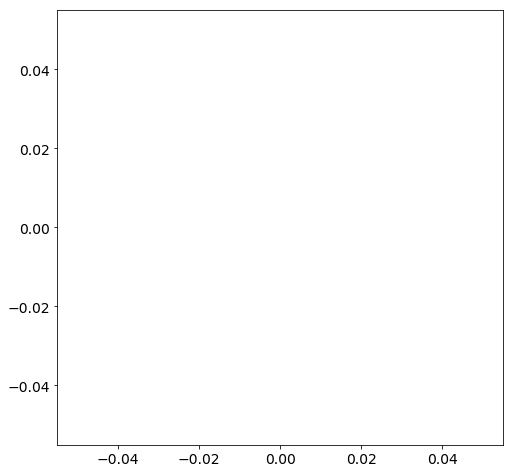

In [56]:
final_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=7,
                                        min_samples_leaf=10,
                                        random_state=42,  
                                        n_estimators=400)

final_model.fit(X_train, y_train)

y_train_preds = final_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

In [ ]:
y_test_preds = final_model.predict(X_test)
evaluate_preds(y_test, y_test_preds, save=True)